# KPI 1: Utilisation rate

* monthly
* daily
* hourly

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", context="talk")


from keplergl import KeplerGl


from datetime import datetime
from datetime import timedelta
import math
import random
import timeit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




## Data Readin:

In [11]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])


    return trip_data



In [143]:
set_utilization(bremen, "weekday")

,weekday,utilization
0,0,7630
1,1,8372
2,2,8872
3,3,8475
4,4,9849
5,5,8146
6,6,6550


### Data Plotting def:

In [219]:
def get_timeperiod(mode):
    return mode["day"].nunique()
    
def set_number_of_columns(timeresolution):  
    if timeresolution == "weekday":
        numberof_columns = 7
    if timeresolution == "hour":
        numberof_columns = 24    
    if timeresolution == "month":
        numberof_columns =  5  



def set_utilization(df, timeresolution):
    number_of_days = get_timeperiod(df)
    numberof_columns = set_number_of_columns(timeresolution)              
    bike_usage = df
    bike_usage["utilization"] = bike_usage["fleetsize_weekly"].apply(lambda x: (numberof_columns) / ( number_of_days ))
    bike_utilization= bike_usage.groupby(timeresolution, as_index= True )["utilization"].sum().reset_index()
    return bike_utilization
    return bike_usage

def set_utilization_ratio(df, timeresolution):
    number_of_days = get_timeperiod(df)
    numberof_columns = set_number_of_columns(timeresolution)              
    bike_usage = df
        # TO_DO berechnung überprüfen
    bike_usage["utilization"] = bike_usage["fleetsize_weekly"].apply(lambda x: (100*numberof_columns) / (x * number_of_days ))
    bike_utilization= bike_usage.groupby(timeresolution, as_index= True )["utilization"].sum().reset_index()
    return bike_utilization



def general_utilization(city_name,lable,provider,dataset,ratio):
    mode = read_data(city_name)


    if ratio == "absolute":
        # differnt temporal_resolutions
        df_hour = set_utilization (mode, "hour")
        df_weekday = set_utilization (mode, "weekday")
        df_month = set_utilization (mode, "month")
      
    if ratio == "compensated":
        # differnt temporal_resolutions
        df_hour = set_utilization_ratio (mode, "hour")
        df_weekday = set_utilization_ratio (mode, "weekday")
        df_month = set_utilization_ratio (mode, "month")
    
    # plots
    fig1, (ax1) = plt.subplots(1, 1, figsize=(15,5))
    fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(15,5))

    sns.barplot(x="hour", y="utilization", data=df_hour, palette="rocket", ax=ax1)
    sns.barplot(x="weekday", y="utilization", data=df_weekday, palette="rocket", ax=ax2)
    sns.barplot(x="month", y="utilization", data=df_month, palette="rocket", ax=ax3) 
    
    # add mean utilization line to plot
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
    ax1.axhline(y = df_hour['utilization'].mean(), color='red', linewidth=2, alpha=.7)
    ax1.set(xlabel='Hours', ylabel="Average "+lable+" utilization")
    ax1.set_title(provider+": Average "+lable+" utilization per hour")

    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
    ax2.axhline(y = df_weekday['utilization'].mean(), color='red', linewidth=2, alpha=.7)
    ax2.set(xlabel='Weekdays', ylabel="Average "+lable+" utilization")
    ax2.set_title(provider+": Average "+lable+" utilization per weekday")

    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=40, ha="right")
    ax3.axhline(y = df_month['utilization'].mean(), color='red', linewidth=2, alpha=.7)
    ax3.set(xlabel='Month', ylabel="Average "+lable+" utilization")
    ax3.set_title(provider+": Average "+lable+" utilization per month" ) 
    
    
#    fig1.savefig("Test_Pictures/general_utilization_hour_"+provider+"_"+lable+"_"+dataset+".pdf")
#    fig2.savefig("Test_Pictures/general_utilization_month&weekday_"+provider+"_"+lable+"_"+dataset+".pdf")

    fig1.tight_layout()
    fig2.tight_layout()
    return 

## Regression def:

In [215]:
def weather_utilization_regression (data, mode):
    
    plot_weather_regression(data, "wind", "rounded_time_hourly", mode)
    plot_weather_regression(data, "rain", "rounded_time_hourly", mode)
    plot_weather_regression(data, "temp", "rounded_time_hourly", mode)
    
    plot_weather_regression(data, "wind", "day", mode)
    plot_weather_regression(data, "rain", "day", mode)
    plot_weather_regression(data, "temp", "day", mode)
    
    
def set_dataset_absolute(data,group_by,condition):
    weather = pd.DataFrame()
    weather[condition] = data.groupby(group_by)[condition].mean()
    weather["number_ids"]= data.groupby(group_by)["b_number"].count()
    return weather


def set_dataset_compensated(data,group_by,condition):
    weather = pd.DataFrame()
    weather[condition] = data.groupby(group_by)[condition].mean()
    data["utilization"] = data["fleetsize_weekly"].apply(lambda x: (1 / x)*100)

    weather["number_ids"]= data.groupby(group_by)["utilization"].sum()
    return weather
    
    
    
    
    
def plot_weather_regression (data,condition,timeresolution,mode):
    if mode == "absolute":
        weather_data = set_dataset_absolute(data,timeresolution,condition)
    
    if mode == "compensated":
        weather_data = set_dataset_compensated(data,timeresolution,condition)


    X = weather_data[condition].values.reshape((-1,1)) 
    y = weather_data["number_ids"]
    # initialize model
    lin_mod = LinearRegression()
    
    

#train model
    lin_mod.fit(X, y)

#make predictions using model
    model_pred = lin_mod.predict(X)

# plot results
    plt.figure(figsize = (8,6))
    plt.scatter(X, y, marker="x")
    plt.xlabel(condition+" "+timeresolution)
    plt.ylabel("Demand hourly")
    plt.plot(X, model_pred, c='C2')
    plt.legend(['Squared loss fit','Observed days'])
    print(lin_mod.coef_, lin_mod.intercept_)



# Utilization rate plots Duesseldorf:

In [217]:
general_utilization("duesseldorf","bike","Duesseldorf","dataset","compensated")


TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [218]:
general_utilization("duesseldorf","bike","Duesseldorf","dataset","absolute")



TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

[0.04106496] 7.2342866843144344
[-1.15958725] 7.45660479120085
[0.85746395] -4.574634195945084
[-14.34234539] 186.49328789555554
[-168.73356474] 129.1854989058963
[16.74623706] -105.02106289844586


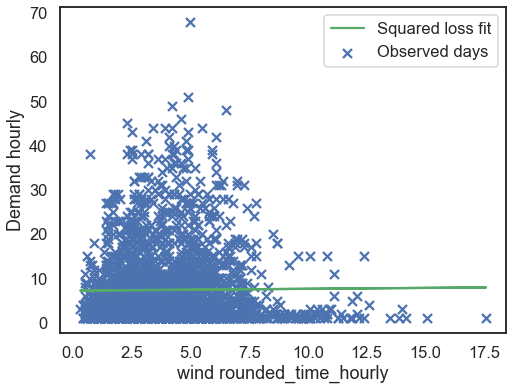

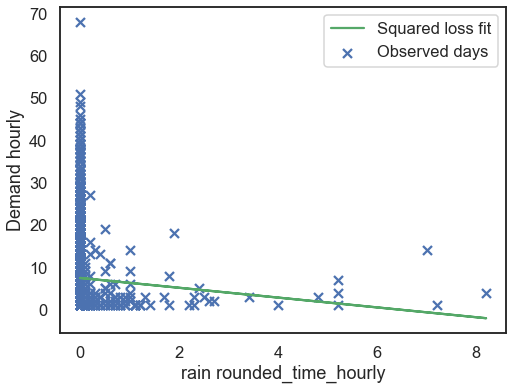

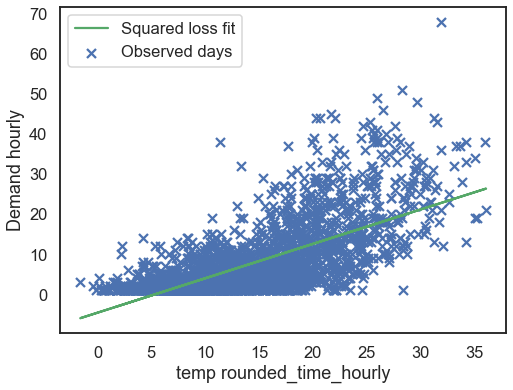

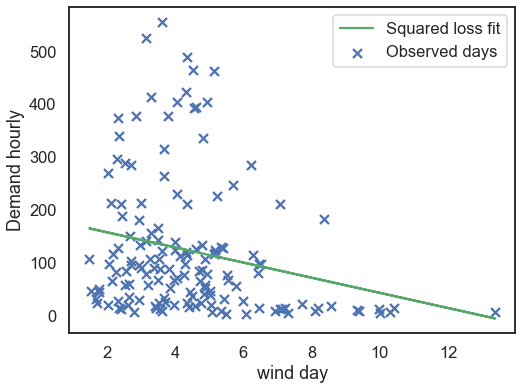

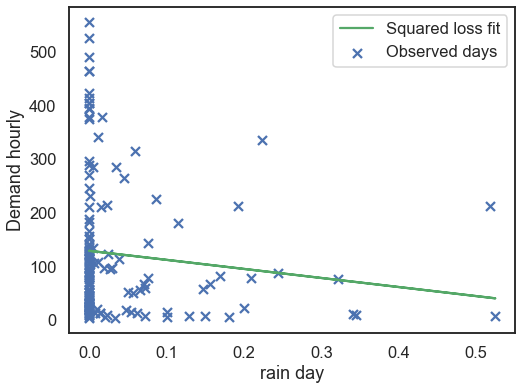

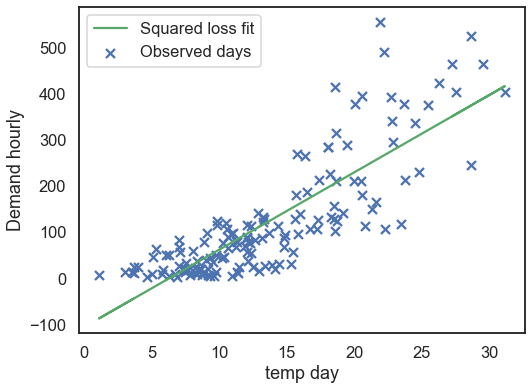

In [208]:
duesseldorf = read_data("duesseldorf")
weather_utilization_regression(duesseldorf,"absolute")


[0.15620897] 2.3704224432729792
[-0.38019068] 3.0042389492927377
[0.12410947] 1.2516737211849434
[-3.28546487] 64.12597263899247
[-38.41855109] 50.98923881337364
[2.7080147] 12.688553763582838


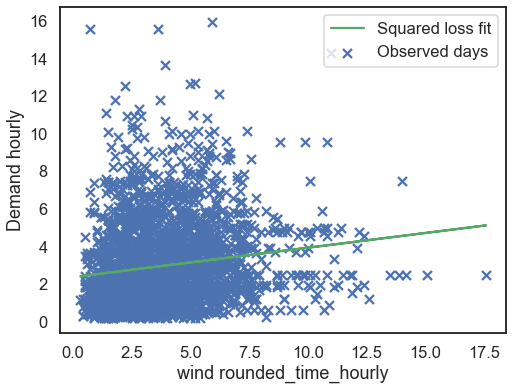

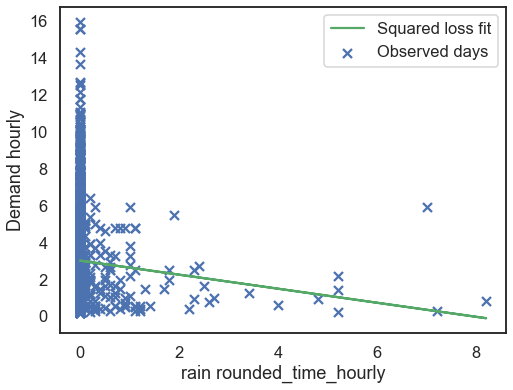

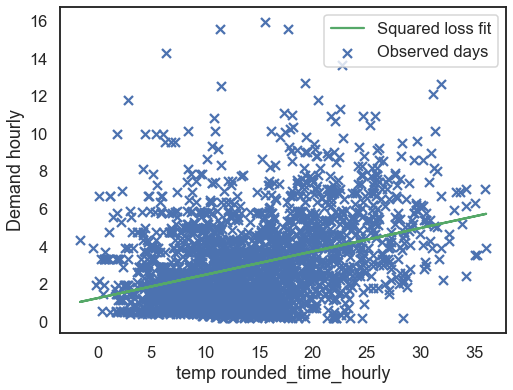

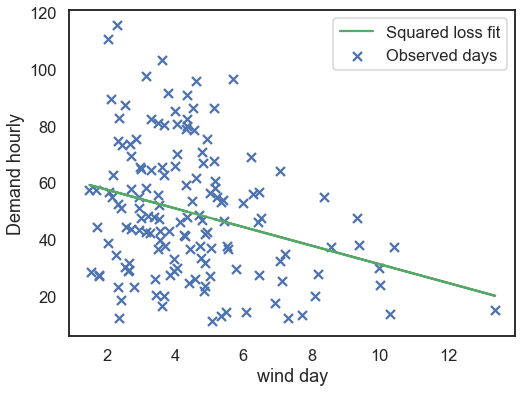

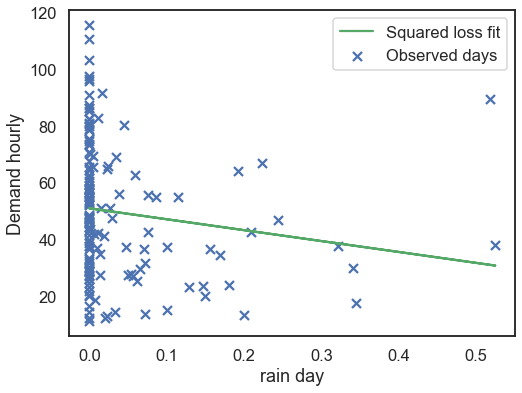

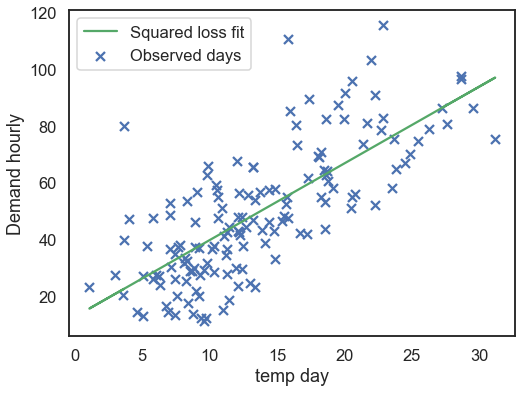

In [216]:
weather_utilization_regression(duesseldorf,"compensated")



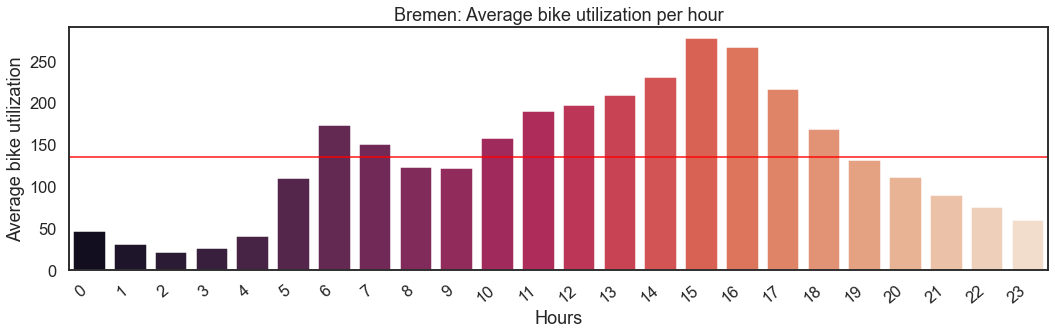

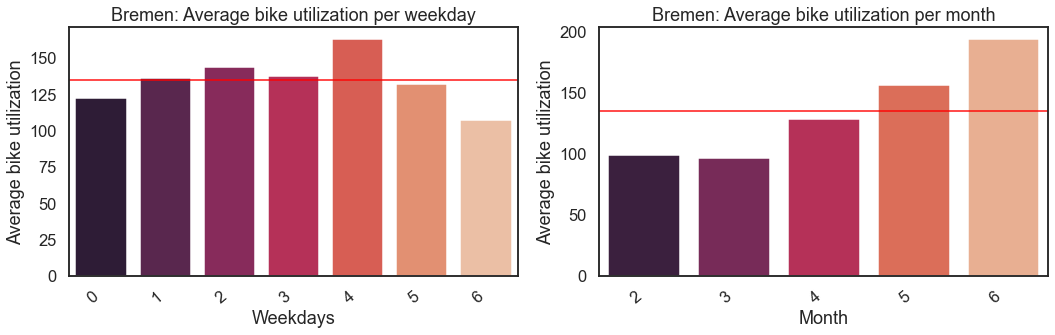

In [153]:
general_utilization("bremen","bike","Bremen","dataset","compensated")

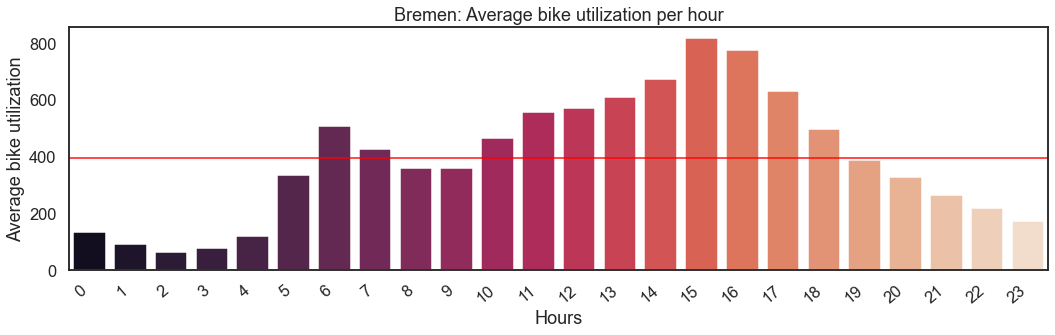

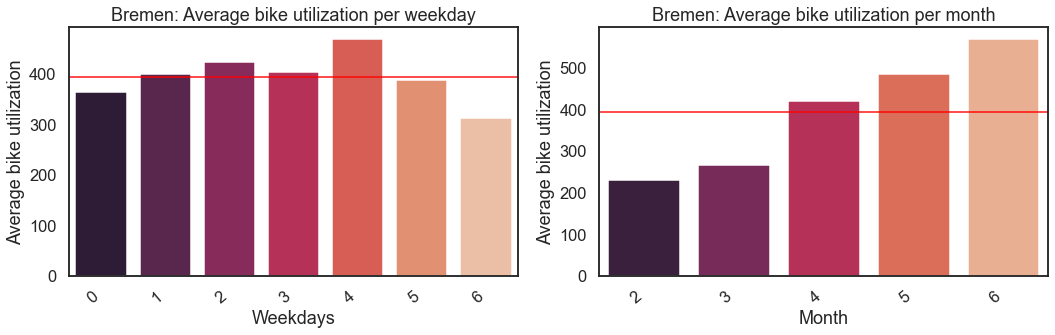

In [154]:
general_utilization("bremen","bike","Bremen","dataset","absolute")

[-20.68187295] 492.2698325945259
[-381.20240355] 409.43058741517575
[18.26121126] 168.49777701415158


KeyError: 'wind'

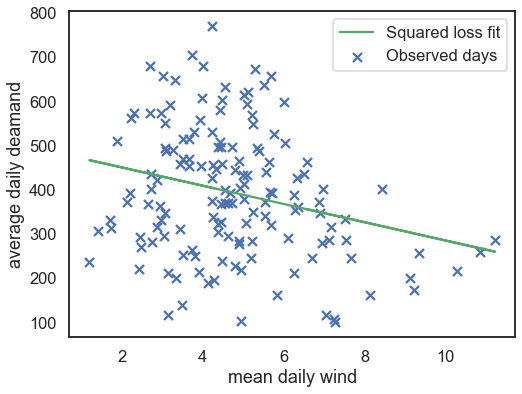

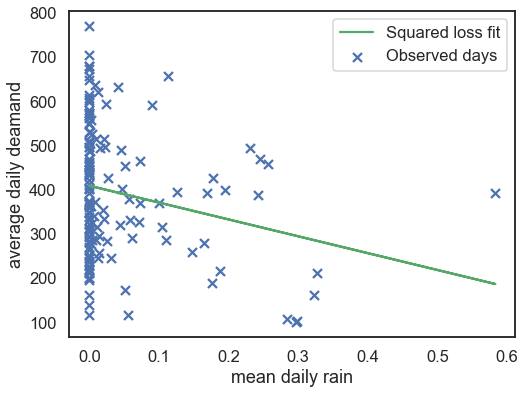

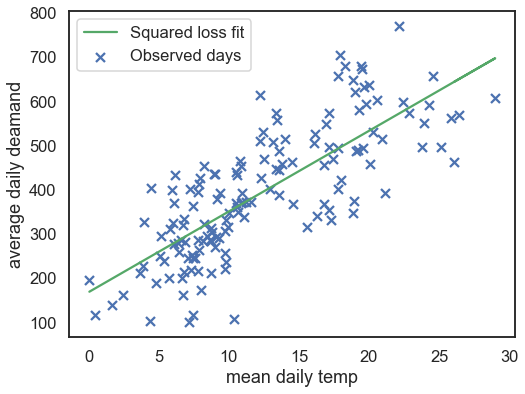

In [164]:
weather_utilization_regression(read_data("bremen"))

In [15]:
def get_daily_fleet_size (fleet, timeresolution):
    fleet["day"] = pd.to_datetime(fleet["day"],format='%Y%m%d')
    fleet["week"] = fleet["day"].dt.isocalendar().week


    first = fleet["day"].iloc[0]
    last = fleet["day"].iloc[-1]
    i = (last-first)/np.timedelta64(1,'D')
    test = first + pd.to_timedelta(np.arange(int(i)+1), 'D')
    plot = pd.DataFrame(test)
    plot = plot.set_index(test)
    plot = pd.DataFrame((fleet.groupby(timeresolution)["b_number"].nunique()))
    return plot

In [16]:
def plot_daily_fleet_size(fleet, city, timeresolution):   
    daily_fleet_size = get_daily_fleet_size(fleet,timeresolution)
    fig,ax = plt.subplots(figsize=(15,5), dpi= 80)
    ax.plot(daily_fleet_size.index, daily_fleet_size["b_number"])
    ax.set_xlabel(timeresolution+"s")
    ax.set_ylabel("Number of bikes per "+ timeresolution)
    ax.set_title(city+": Number of bikes per "+timeresolution )
    print(daily_fleet_size["b_number"].mean())
    plt.savefig("Project_Data/Graphics"+city+"_"+timeresolution+".pdf")
    plt.show()

194.5909090909091


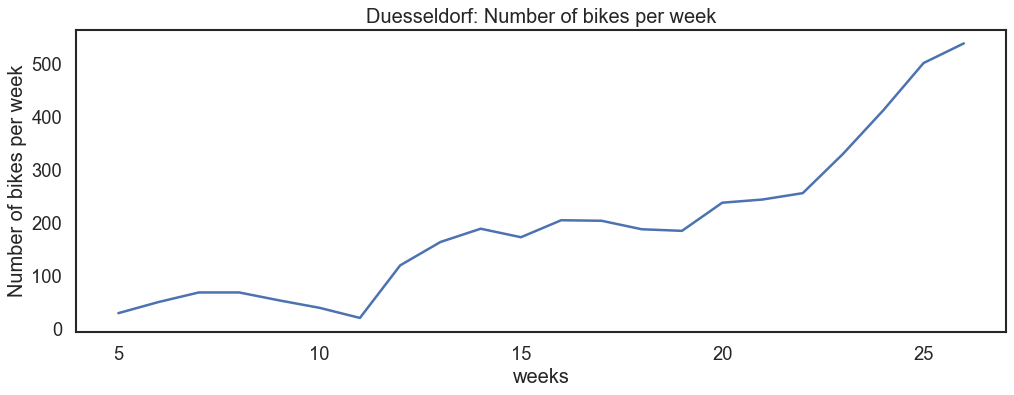

326.6


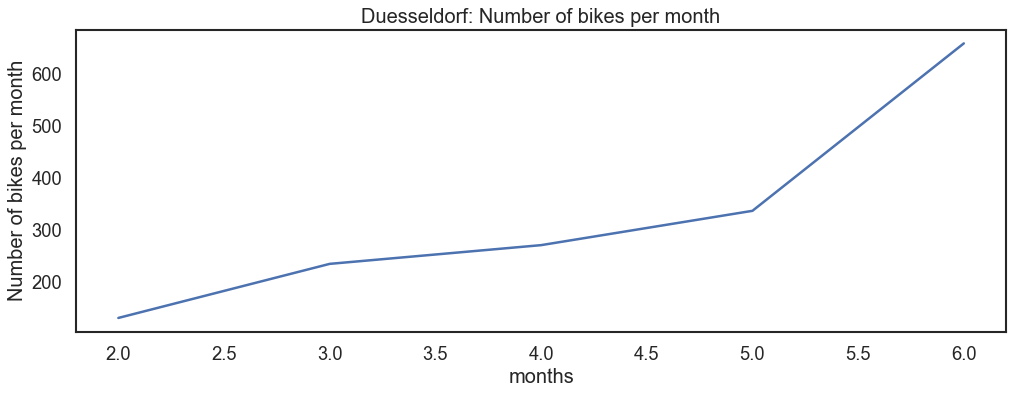

69.89115646258503


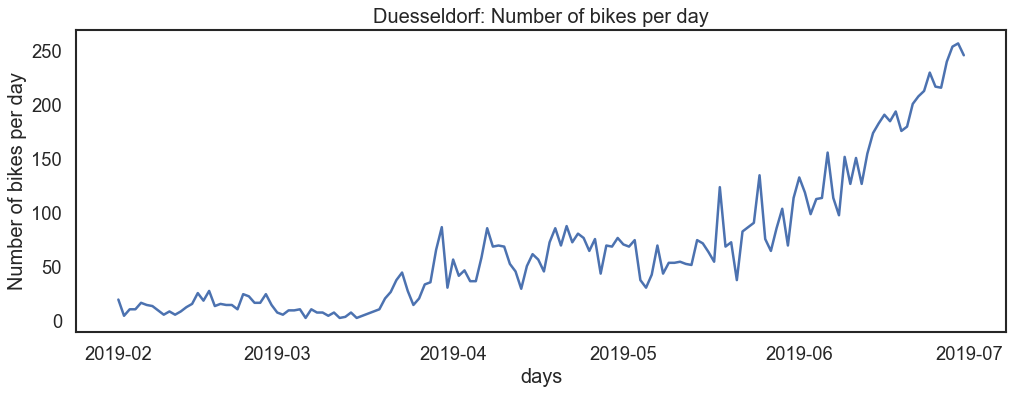

In [17]:
duesseldorf = read_data("duesseldorf")


plot_daily_fleet_size(duesseldorf, "Duesseldorf", "week")
plot_daily_fleet_size(duesseldorf, "Duesseldorf",  "month")
plot_daily_fleet_size(duesseldorf, "Duesseldorf",  "day")

150.03401360544217


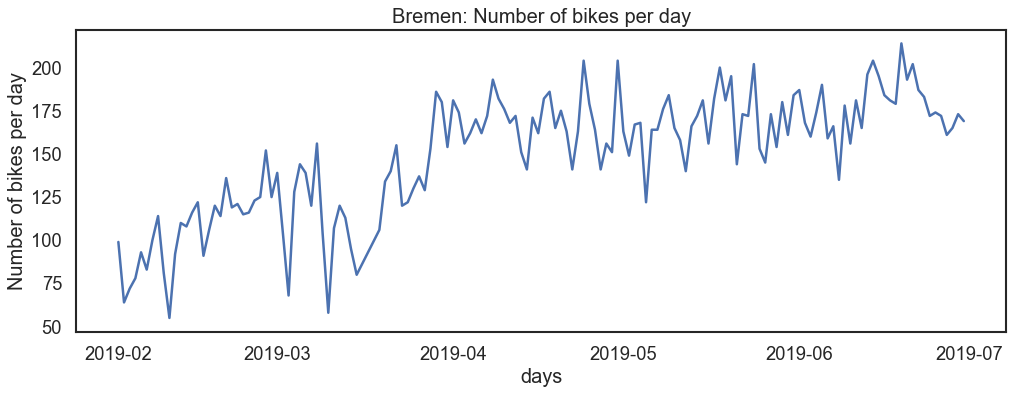

283.95454545454544


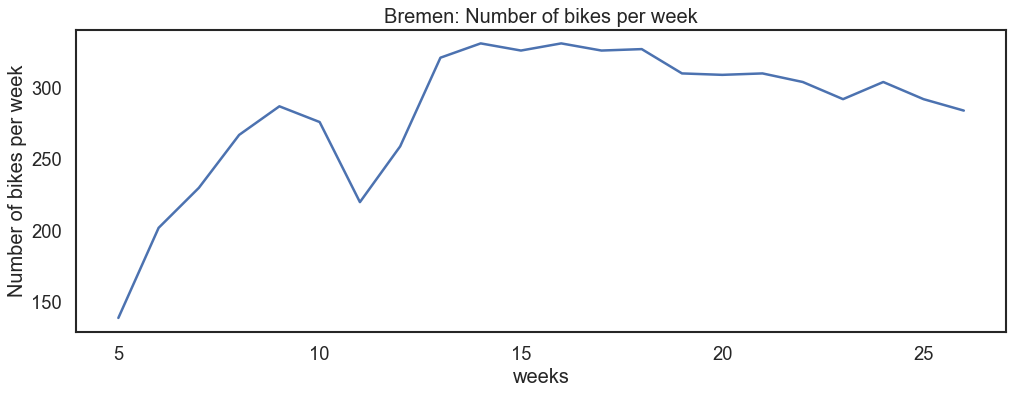

366.8


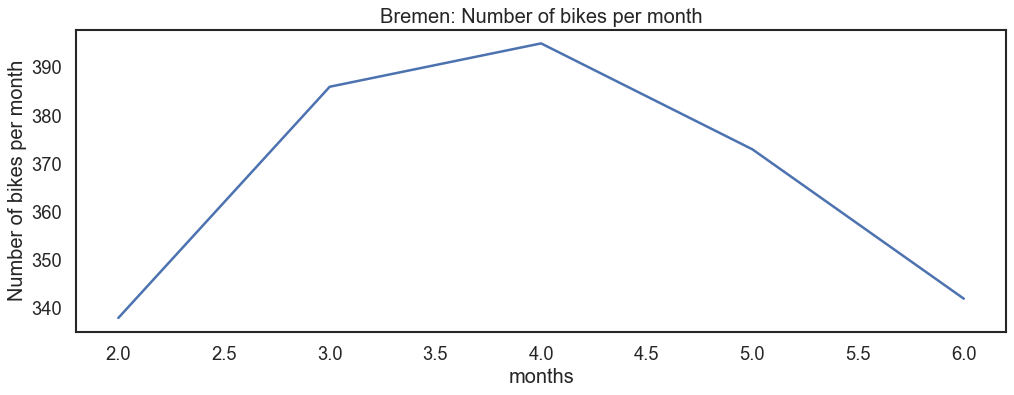

In [18]:
bremen = read_data("bremen")
plot_daily_fleet_size(bremen, "Bremen",  "day")
plot_daily_fleet_size(bremen, "Bremen",  "week")
plot_daily_fleet_size(bremen, "Bremen",  "month")

In [60]:
car2go_E_charging_map = KeplerGl(height=1000)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [61]:
car2go_E_charging_map.add_data(data=bremen,name='callabike_all_real_trips')


In [62]:
car2go_E_charging_map



KeplerGl(data={'callabike_all_real_trips': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…

In [212]:
duesseldorf

,Unnamed: 0,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,...,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain,fleetsize_weekly,fleetsize_monthly,fleetsize_dayly
0,0,2019-02-06,15:35:00,538,duesseldorf,0 days 00:17:00,51.218927,6.765862,51.240644,6.781982,...,2.662958,0.283333,9.398675,2019-02-06 16:00:00,9.5,5.0,0.0,51,131,15
1,1,2019-02-19,15:57:00,538,duesseldorf,0 days 00:23:00,51.213766,6.751624,51.223056,6.779230,...,2.182598,0.383333,5.693734,2019-02-19 16:00:00,10.3,5.6,0.0,69,131,16
2,2,2019-03-22,13:20:00,538,duesseldorf,0 days 01:20:00,51.229671,6.797855,51.218527,6.794867,...,1.256486,1.333333,0.942365,2019-03-22 13:00:00,19.0,3.5,0.0,120,235,38
3,3,2019-03-27,06:34:00,538,duesseldorf,0 days 00:22:00,51.218527,6.794867,51.252515,6.782041,...,3.883302,0.366667,10.590823,2019-03-27 07:00:00,4.8,0.5,0.0,164,235,34
4,4,2019-03-28,14:54:00,538,duesseldorf,0 days 00:12:00,51.252515,6.782041,51.242592,6.782100,...,1.103349,0.200000,5.516746,2019-03-28 15:00:00,12.5,1.7,0.0,164,235,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18033,18033,2019-06-09,20:49:00,52817,duesseldorf,0 days 00:42:00,51.227590,6.772325,51.226898,6.771832,...,0.084326,0.700000,0.120466,2019-06-09 21:00:00,17.9,3.3,0.0,330,659,152
18034,18034,2019-06-10,10:42:00,52817,duesseldorf,0 days 00:53:00,51.226898,6.771832,51.229461,6.777001,...,0.459157,0.883333,0.519800,2019-06-10 11:00:00,22.6,1.9,0.0,412,659,127
18035,18035,2019-06-10,20:17:00,52817,duesseldorf,0 days 00:04:00,51.229461,6.777001,51.229505,6.776754,...,0.017920,0.066667,0.268800,2019-06-10 20:00:00,17.3,3.2,0.0,412,659,127
18036,18036,2019-06-17,12:47:00,52817,duesseldorf,0 days 00:19:00,51.237900,6.789368,51.222489,6.813165,...,2.383758,0.316667,7.527656,2019-06-17 13:00:00,26.1,2.9,0.0,501,659,185
